# Particle Flow Network Classification with tf Dataset

In [1]:
import uproot as ur
import awkward as ak
import numpy as np

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
import tensorflow as tf

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from tensorflow.keras.utils import to_categorical

2021-09-28 03:49:39.046894: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
import sys
sys.path.append('/home/dportill/LCStudies')
from  util import graph_util as gu

In [5]:
# my worspace and directories
path_prefix = '/home/dportill/LCStudies/'
plotpath = path_prefix+'classifier/Plots_EFN/'
modelpath = path_prefix+'classifier/Models_EFN/'

In [6]:
import time as t

In [7]:
import matplotlib.pyplot as plt

# Load Data

## X

In [8]:
Xraw = np.load('/data/atlas/dportill/X_20_files.npy', mmap_mode='r')

In [11]:
# shape: (total number of clusters, total number of cells, [log(E),eta,phi,sampleID,rperp])
Xraw.shape

(114485, 743, 6)

Read first 4 cell features:  [log(E),eta,phi,sampleID]

In [15]:
X = np.lib.format.open_memmap('/data/atlas/dportill/X_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Xraw.shape[0], Xraw.shape[1], 4))
np.copyto(dst=X, src=Xraw[:,:,:4], casting='same_kind', where=True)

## Y

In [17]:
Yraw = np.load('/data/atlas/dportill/Y_20_files.npy', mmap_mode='r')

In [18]:
# shape: (total number of events, 1) 
Yraw.shape

(114485, 2)

In [19]:
Yraw

memmap([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [20]:
#Y = np.lib.format.open_memmap('/data/atlas/dportill/Y_STSC_notebook.npy',
#                             mode='w+', dtype=np.float64, shape=(Yraw.shape))
#np.copyto(dst=Y, src=Yraw[:,:], casting='same_kind', where=True)

## Checks 

Categorical not working for pi0

In [23]:
Y_list = Y.tolist()

In [28]:
len(Y_list)

114485

In [33]:
pipm_count = Y_list.count([0.0, 1.0])   # pipm label =1 
pi0_count = Y_list.count([1.0, 0.0])    #pi0 label = 0
pi0_count2 = Y_list.count([1.0, 1.0])    #pi0 label = 0
print('pipm events ', pipm_count)
print('pi0 events  ', pi0_count)
print('pi0_count2  ', pi0_count2)

pipm events  68113
pi0 events   0
pi0_count2   46372


In [35]:
Y_test = to_categorical(np.ones( pi0_count2) * 0)

In [36]:
Y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [37]:

Y_test = tf.keras.utils.to_categorical(np.concatenate((np.ones(pipm_count), np.zeros(pi0_count2))))

In [38]:
Y_test

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [42]:
Y_test.shape

(114485, 2)

## Y again

In [44]:
Y = np.lib.format.open_memmap('/data/atlas/dportill/Y_STSC_notebook.npy',
                             mode='w+', dtype=np.float64, shape=(Y_test.shape))
np.copyto(dst=Y, src=Y_test[:,:], casting='same_kind', where=True)

In [46]:
Y

memmap([[0., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [50]:
print("X shape", X.shape)
print("Y shape", Y.shape)

X shape (114485, 743, 4)
Y shape (114485, 2)


## tf Dataset

In [48]:
deepSets = tf.data.Dataset.from_tensor_slices((X, Y))

2021-09-28 04:36:13.943054: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-28 04:36:13.999263: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-28 04:36:14.140129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1746] Found device 0 with properties: 
pciBusID: 0000:b2:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-09-28 04:36:14.141756: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-28 04:36:14.197168: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-28 04:36:14.197353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [49]:
deepSets

<TensorSliceDataset shapes: ((743, 4), (2,)), types: (tf.float64, tf.float64)>

In [53]:
Total = deepSets.cardinality().numpy()
print("Total Number of  CLUSTERS (point clouds?): ", Total)

Total Number of  CLUSTERS (point clouds?):  114485


In [54]:
val= int(Total*0.15)
test= int(Total*0.15)
train=Total-test-val

In [55]:
print("train:", train)
print("test:" ,test)
print("val:" ,val)

train: 80141
test: 17172
val: 17172


In [56]:
ds_train = deepSets.skip(val+test)

In [57]:
ds_test = deepSets.take(test+val)
ds_val = ds_test.skip(test)
ds_test = ds_test.take(test)

In [58]:
print(ds_train.cardinality())
print(ds_val.cardinality())
print(ds_test.cardinality())

tf.Tensor(80141, shape=(), dtype=int64)
tf.Tensor(17172, shape=(), dtype=int64)
tf.Tensor(17172, shape=(), dtype=int64)


## Determine number of batches

In [60]:
print("len X ", len(X))
print("len Y ", len(Y))

len X  114485
len Y  114485


In [61]:
80141+17172+17172

114485

In [62]:
batch_size = 1000 #3000 ?

Nevts = len(X)
Nbatches = int(np.floor(Nevts/batch_size))
print(Nbatches)


114


In [63]:
ds_train = ds_train.batch(Nbatches, drop_remainder=True)
ds_val = ds_val.batch(Nbatches, drop_remainder=True)
ds_test = ds_test.batch(Nbatches, drop_remainder=True)

# The PFN Model 

In [64]:
# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [65]:
X.shape[-1]

4

## Russel's PFN Model 

In [66]:
# network architecture parameters
netOpt2 = tf.keras.optimizers.Adam(
    learning_rate=.005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-09,
    amsgrad=False)

In [67]:
pfn2 = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, 
          optimizer=netOpt2, metrics=[])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
t0 = t.time()
history2 = pfn2.fit(ds_train,
        epochs=100,
        validation_data=ds_val,
        verbose=1)
t1 = t.time()

Epoch 1/100
702/702 [==============================] - 11s 15ms/step - loss: 28.0165 - val_loss: 812.0226
Epoch 2/100
702/702 [==============================] - 11s 16ms/step - loss: 24.5373 - val_loss: 1221.6089
Epoch 3/100
702/702 [==============================] - 10s 14ms/step - loss: 7.8954 - val_loss: 103.9546
Epoch 4/100
702/702 [==============================] - 11s 15ms/step - loss: 1.0876 - val_loss: 221.4636
Epoch 5/100
702/702 [==============================] - 11s 16ms/step - loss: 6.2060 - val_loss: 411.8862
Epoch 6/100
702/702 [==============================] - 10s 14ms/step - loss: 1.5968 - val_loss: 189.8811
Epoch 7/100
702/702 [==============================] - 10s 14ms/step - loss: 1.2121 - val_loss: 59.7183
Epoch 8/100
702/702 [==============================] - 10s 14ms/step - loss: 0.4135 - val_loss: 18.5954
Epoch 9/100
702/702 [==============================] - 10s 14ms/step - loss: 0.5209 - val_loss: 14.3511
Epoch 10/100
702/702 [==============================] -

In [75]:
pfn2.save(modelpath+'pfn_tfdataset_test_clust_20Files_100ep.h5')

In [74]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 1237.170426607132 (s)
20.619507110118867 (min)
0.34365845183531446 (hour)


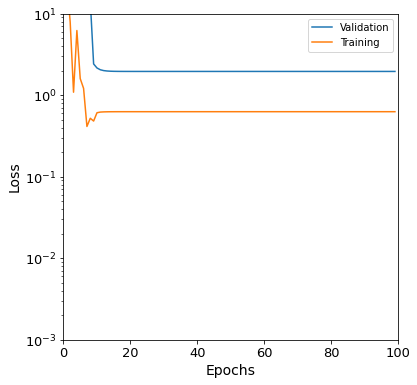

In [73]:
# 40 files with netOpt2
M = len(history2.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history2.history['val_loss'], label="Validation")
plt.plot(history2.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.tight_layout()
#plt.savefig('./.png', format='png')
plt.show()

## PFN Model 

In [76]:
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes )

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_7 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_7[0][0]               
____________________________________________________________________________________________

In [77]:
t0 = t.time()
history = pfn.fit(ds_train,
        epochs=100,
        validation_data=ds_val,
        verbose=1)
t1 = t.time()

Epoch 1/100
702/702 [==============================] - 11s 15ms/step - loss: 23.1283 - acc: 0.9941 - val_loss: 5636.9458 - val_acc: 0.0000e+00
Epoch 2/100
702/702 [==============================] - 10s 14ms/step - loss: 160.0243 - acc: 0.9278 - val_loss: 1201.0864 - val_acc: 0.0000e+00
Epoch 3/100
702/702 [==============================] - 10s 14ms/step - loss: 42.3166 - acc: 0.9023 - val_loss: 81.1210 - val_acc: 0.0000e+00
Epoch 4/100
702/702 [==============================] - 10s 14ms/step - loss: 3.7873 - acc: 0.9247 - val_loss: 28.6458 - val_acc: 0.0000e+00
Epoch 5/100
702/702 [==============================] - 10s 14ms/step - loss: 1.2009 - acc: 0.9193 - val_loss: 157.7557 - val_acc: 4.0936e-04
Epoch 6/100
702/702 [==============================] - 11s 15ms/step - loss: 3.9641 - acc: 0.9511 - val_loss: 48.0152 - val_acc: 0.0026
Epoch 7/100
702/702 [==============================] - 10s 14ms/step - loss: 1.3417 - acc: 0.9333 - val_loss: 39.4518 - val_acc: 0.0046
Epoch 8/100
702/702

In [78]:
pfn.save(modelpath+'pfn_tfdataset_test_clust_20Files_100ep_noopt.h5')

In [79]:
print('Time to train: '+str(t1-t0)+' (s)')
print(str((t1-t0)/60)+' (min)')
print(str((t1-t0)/3600)+' (hour)')

Time to train: 1218.3118824958801 (s)
20.305198041598 (min)
0.3384199673599667 (hour)


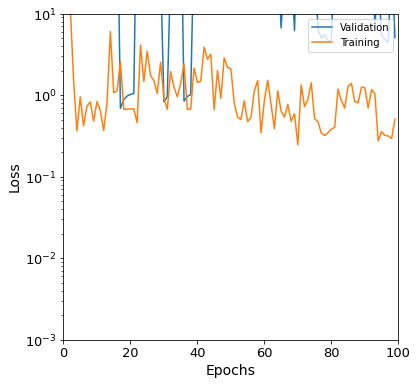

In [80]:
# NO netOpt2
M = len(history.history['val_loss'])
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,M)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.tight_layout()
#plt.savefig('./.png', format='png')
plt.show()